 **Importing Libraries**


In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, classification_report

import matplotlib.pyplot as plt


**Load Dataset**

In [2]:
data = pd.read_csv("heart_disease_data.csv")
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


**Features, Target, Sensitive Attributes**

In [3]:
TARGET = "target"
SENSITIVE_ATTR = "sex"

X = data.drop(columns=[TARGET])
y = data[TARGET]

**Train-Test Split**

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

**Baseline Models**

In [5]:
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

rf = RandomForestClassifier(n_estimators=200, random_state=42)


**Train & Evaluate Models**

In [6]:
models = {"Logistic Regression": log_reg, "Random Forest": rf}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, probs)
    results[name] = probs
    print(f"{name} ROC-AUC: {auc:.3f}")

Logistic Regression ROC-AUC: 0.847
Random Forest ROC-AUC: 0.880


**Fairness Functions**

In [7]:
def false_negative_rate(y_true, y_pred):
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))
    return fn / (fn + tp + 1e-8)


def evaluate_fairness(y_true, y_probs, sensitive_values, threshold=0.5):
    y_pred = (y_probs >= threshold).astype(int)
    fairness = {}
    for group in np.unique(sensitive_values):
        idx = sensitive_values == group
        fnr = false_negative_rate(y_true[idx], y_pred[idx])
        fairness[group] = fnr
    return fairness

**Baseline Fairness Results**

In [8]:
sex_test = X_test[SENSITIVE_ATTR]
baseline_fairness = evaluate_fairness(y_test.values, results["Logistic Regression"], sex_test)

for group, fnr in baseline_fairness.items():
    print(f"Group {group}: FNR = {fnr: .3f}")

Group 0: FNR =  0.100
Group 1: FNR =  0.190


**Bias Mitigation**

In [14]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weight_dict = dict(zip(classes, weights))

# Mitigated model using class_weight

mitigated_model = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=1000,
        class_weight=class_weight_dict

    ))

])

mitigated_model.fit(X_train, y_train)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


**Evaluate Mitigated Model**

In [15]:
mitigated_probs = mitigated_model.predict_proba(X_test)[:, 1]
mitigated_auc = roc_auc_score(y_test, mitigated_probs)

mitigated_fairness = evaluate_fairness(
    y_test.values,
    mitigated_probs,
    sex_test
)

print("Mitigated ROC-AUC:", round(mitigated_auc, 3))
for group, fnr in mitigated_fairness.items():
    print(f"Group {group}: FNR = {fnr:.3f}")

Mitigated ROC-AUC: 0.849
Group 0: FNR = 0.100
Group 1: FNR = 0.238


**Final Classification Report**

In [16]:
print(classification_report(y_test, (mitigated_probs >= 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.77      0.66      0.71        35
           1       0.74      0.83      0.78        41

    accuracy                           0.75        76
   macro avg       0.75      0.74      0.74        76
weighted avg       0.75      0.75      0.75        76



**Visualization**

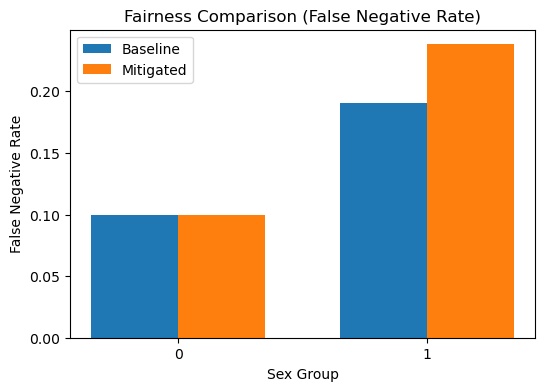

In [18]:
groups = list(baseline_fairness.keys())
baseline_values = list(baseline_fairness.values())
mitigated_values = list(mitigated_fairness.values())

x = np.arange(len(groups))
width = 0.35

plt.figure(figsize=(6,4))

plt.bar(x - width/2, baseline_values, width, label="Baseline")
plt.bar(x + width/2, mitigated_values, width, label="Mitigated")

plt.xticks(x, groups)
plt.ylabel("False Negative Rate")
plt.xlabel("Sex Group")
plt.title("Fairness Comparison (False Negative Rate)")
plt.legend()

plt.show()

